In [1]:
from qwen2.modeling_qwen2 import Qwen2ForCausalLM
from transformers import AutoTokenizer
import torch
from copy import deepcopy
from tqdm import tqdm

/home/mengfanxu/miniconda3/envs/transmla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Qwen2ForCausalLM.from_pretrained("/data2/mengfanxu/huggingface/Qwen2.5-0.5B-Instruct", attn_implementation="sdpa", device_map='cuda:1')
tokenizer = AutoTokenizer.from_pretrained("/data2/mengfanxu/huggingface/Qwen2.5-0.5B-Instruct")
model

Some weights of Qwen2ForCausalLM were not initialized from the model checkpoint at /data2/mengfanxu/huggingface/Qwen2.5-0.5B-Instruct and are newly initialized: ['model.layers.0.self_attn.k_up_proj.weight', 'model.layers.0.self_attn.v_up_proj.weight', 'model.layers.1.self_attn.k_up_proj.weight', 'model.layers.1.self_attn.v_up_proj.weight', 'model.layers.10.self_attn.k_up_proj.weight', 'model.layers.10.self_attn.v_up_proj.weight', 'model.layers.11.self_attn.k_up_proj.weight', 'model.layers.11.self_attn.v_up_proj.weight', 'model.layers.12.self_attn.k_up_proj.weight', 'model.layers.12.self_attn.v_up_proj.weight', 'model.layers.13.self_attn.k_up_proj.weight', 'model.layers.13.self_attn.v_up_proj.weight', 'model.layers.14.self_attn.k_up_proj.weight', 'model.layers.14.self_attn.v_up_proj.weight', 'model.layers.15.self_attn.k_up_proj.weight', 'model.layers.15.self_attn.v_up_proj.weight', 'model.layers.16.self_attn.k_up_proj.weight', 'model.layers.16.self_attn.v_up_proj.weight', 'model.layers.

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaMLAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (k_up_proj): Linear(in_features=128, out_features=896, bias=False)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_up_proj): Linear(in_features=128, out_features=896, bias=False)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (in

In [3]:
hidden_size = model.config.hidden_size
n_heads = model.config.num_attention_heads
kv_heads = model.config.num_key_value_heads
head_dim = model.config.hidden_size//model.config.num_attention_heads
kv_groups = model.config.num_attention_heads // model.config.num_key_value_heads

In [4]:
# Insert identity matrices
for name,module in model.named_modules():
    if 'k_up_proj' in name or "v_up_proj" in name:
        module.weight.data = torch.stack([torch.eye(kv_heads*head_dim).reshape(kv_heads, head_dim, kv_heads*head_dim)]*kv_groups,dim=1).reshape(hidden_size, kv_heads*head_dim).contiguous().to(module.weight.data.device,module.weight.data.dtype)

In [5]:
output = model.generate(**tokenizer("Give me a short introduction to large language model.",return_tensors="pt").to("cuda:1"), max_new_tokens=16)
tokenizer.batch_decode(output)

['Give me a short introduction to large language model. Large Language Model (LLM) is a type of artificial intelligence that can generate']

In [6]:
for name,module in tqdm(model.named_modules()):
    if name.endswith("self_attn"):
        # Orthogonal k_proj and k_up_proj
        k_up_weight = deepcopy(module.k_up_proj.weight.data).reshape(hidden_size, kv_heads, head_dim) # (hidden_size, kv_heads, head_dim)
        k_weight = deepcopy(module.k_proj.weight.data).reshape(kv_heads, head_dim, hidden_size) # (kv_heads, head_dim, hidden_size)
        if module.k_proj.bias is not None:
            k_weight = torch.cat([k_weight,deepcopy(module.k_proj.bias.data).reshape(kv_heads, head_dim,1)],dim=-1)
        k_up_k = torch.einsum("Dhd,hdL->hDL",k_up_weight, k_weight) # (kv_heads, hidden_size, hidden_size), rank<=head_dim
        U,S,V = torch.svd_lowrank(k_up_k, head_dim, niter=head_dim) # U(kv_heads, hidden_size, head_dim), S(kv_heads, head_dim), V(kv_heads, hidden_size, head_dim)
        US_sqrt = torch.einsum('hDd,hd->Dhd',U,torch.sqrt(S)) # (latent_dim, kv_heads, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (kv_heads, head_dim, latent_dim)
        if module.k_proj.bias is not None:
            module.k_proj.bias.data = S_sqrtV[:,:,-1].reshape(-1).contiguous()
            S_sqrtV = S_sqrtV[:,:,:-1]
        module.k_up_proj.weight.data = US_sqrt.reshape(hidden_size, kv_heads*head_dim).contiguous()
        module.k_proj.weight.data = S_sqrtV.reshape(kv_heads*head_dim, hidden_size).contiguous()
        # Orthogonal v_proj and v_up_proj
        v_up_weight = deepcopy(module.v_up_proj.weight.data).reshape(hidden_size, kv_heads, head_dim) # (hidden_size, kv_heads, head_dim)
        v_weight = deepcopy(module.v_proj.weight.data).reshape(kv_heads, head_dim, hidden_size) # (kv_heads, head_dim, hidden_size)
        if module.v_proj.bias is not None:
            v_weight = torch.cat([v_weight,deepcopy(module.v_proj.bias.data).reshape(kv_heads, head_dim,1)],dim=-1)
        v_up_v = torch.einsum("Dhd,hdL->hDL",v_up_weight, v_weight) # (kv_heads, hidden_size, hidden_size), rank<=head_dim
        U,S,V = torch.svd_lowrank(v_up_v, head_dim, niter=head_dim) # U(kv_heads, hidden_size, head_dim), S(kv_heads, head_dim), V(kv_heads, hidden_size, head_dim)
        US_sqrt = torch.einsum('hDd,hd->Dhd',U,torch.sqrt(S)) # (latent_dim, kv_heads, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (kv_heads, head_dim, latent_dim)
        if module.v_proj.bias is not None:
            module.v_proj.bias.data = S_sqrtV[:,:,-1].reshape(-1).contiguous()
            S_sqrtV = S_sqrtV[:,:,:-1]
        module.v_up_proj.weight.data = US_sqrt.reshape(hidden_size, kv_heads*head_dim).contiguous()
        module.v_proj.weight.data = S_sqrtV.reshape(kv_heads*head_dim, hidden_size).contiguous()

391it [00:14, 27.47it/s]


In [7]:
output = model.generate(**tokenizer("Give me a short introduction to large language model.",return_tensors="pt").to("cuda:1"), max_new_tokens=16)
tokenizer.batch_decode(output)

['Give me a short introduction to large language model. Large Language Model (LLM) is an artificial intelligence that can generate human-like']

In [8]:

for name,module in tqdm(model.named_modules()):
    if name.endswith("self_attn"):
        # Orthogonal q_proj and k_up_weight
        """ # conflict with RoPE
        q_weight = deepcopy(module.q_proj.weight.data).reshape(n_heads, head_dim, hidden_size) # (num_head, head_dim, hidden_size)
        k_up_weight = deepcopy(module.k_up_proj.weight.data).reshape(n_heads, head_dim, kv_heads*head_dim) # (num_head, head_dim, latent_dim)
        q_t_k_up = torch.einsum("hdD,hdL->hDL",q_weight, k_up_weight) # (num_head, hidden_size, latent_dim), rank<=head_dim
        U,S,V = torch.svd_lowrank(q_t_k_up, head_dim, niter=head_dim) # U(num_head, hidden_size, head_dim), S(num_head, head_dim), V(num_head, latent_dim, head_dim)
        US_sqrt = torch.einsum('hDd,hd->hdD',U,torch.sqrt(S)) # (hidden_size, num_head, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (num_head, head_dim, latent_dim)
        module.q_proj.weight.data = US_sqrt.reshape(hidden_size, hidden_size).contiguous()
        module.k_up_proj.weight.data = S_sqrtV.reshape(hidden_size, kv_heads*head_dim).contiguous()
        """
        # Orthogonal o_proj and v_up_weight
        o_weight = deepcopy(module.o_proj.weight.data).reshape(hidden_size, n_heads, head_dim).transpose(0,1) # (num_head, hidden_size, head_dim)
        v_up_weight = deepcopy(module.v_up_proj.weight.data).reshape(n_heads, head_dim, kv_heads*head_dim) # (num_head, head_dim, latent_dim)
        o_v_up = torch.einsum("hDd,hdL->hDL",o_weight, v_up_weight) # (num_head, hidden_size, latent_dim), rank<=head_dim
        U,S,V = torch.svd_lowrank(o_v_up, head_dim, niter=head_dim) # U(num_head, hidden_size, head_dim), S(num_head, head_dim), V(num_head, latent_dim, head_dim)
        US_sqrt = torch.einsum('hDd,hd->Dhd',U,torch.sqrt(S)) # (hidden_size, num_head, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (num_head, head_dim, latent_dim)
        module.o_proj.weight.data = US_sqrt.reshape(hidden_size, hidden_size).contiguous()
        module.v_up_proj.weight.data = S_sqrtV.reshape(hidden_size, kv_heads*head_dim).contiguous()
        

391it [00:34, 11.43it/s]


In [9]:
output = model.generate(**tokenizer("Give me a short introduction to large language model.",return_tensors="pt").to("cuda:1"), max_new_tokens=16)
tokenizer.batch_decode(output)

['Give me a short introduction to large language model. Large Language Models (LLMs) are artificial intelligence systems that can generate human-like']

In [10]:
model.save_pretrained("qwen2.5_0.5b_instruct_transMLA")
#model.push_to_hub("fxmeng/qwen2.5_0.5b_instruct_transMLA")

In [11]:
tokenizer.save_pretrained("qwen2.5_0.5b_instruct_transMLA")

('qwen2.5_0.5b_instruct_transMLA/tokenizer_config.json',
 'qwen2.5_0.5b_instruct_transMLA/special_tokens_map.json',
 'qwen2.5_0.5b_instruct_transMLA/vocab.json',
 'qwen2.5_0.5b_instruct_transMLA/merges.txt',
 'qwen2.5_0.5b_instruct_transMLA/added_tokens.json',
 'qwen2.5_0.5b_instruct_transMLA/tokenizer.json')

In [ ]:
model = Qwen2ForCausalLM.from_pretrained("fxmeng/qwen2.5_0.5b_instruct_transMLA", attn_implementation="eager", device_map='cuda:0')
tokenizer = AutoTokenizer.from_pretrained("fxmeng/qwen2.5_0.5b_instruct_transMLA")
output = model.generate(**tokenizer("Give me a short introduction to large language model.",return_tensors="pt").to("cuda:0"), max_new_tokens=16)
tokenizer.batch_decode(output)

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["white", "blue"])

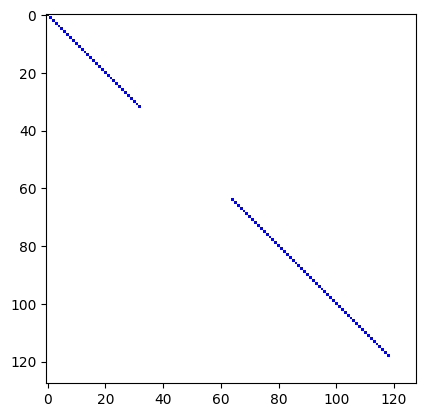

In [13]:
v_weight = model.model.layers[0].self_attn.v_proj.weight.data.to("cpu")
plt.imshow(v_weight@v_weight.T, cmap=cmap, interpolation='none')

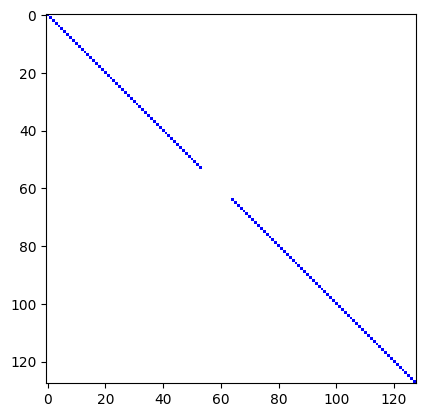

In [14]:
v_up_weight = model.model.layers[0].self_attn.v_up_proj.weight.data.to("cpu")
plt.imshow(v_up_weight.T@v_up_weight, cmap=cmap, interpolation='none')

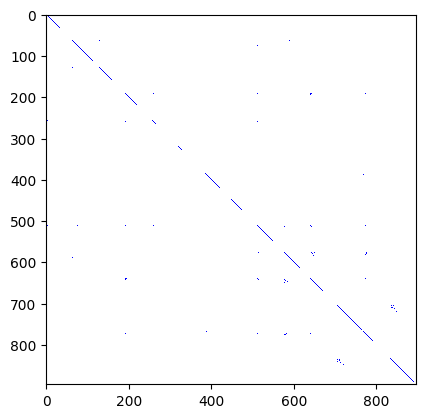

In [15]:
o_weight = model.model.layers[0].self_attn.o_proj.weight.data.to("cpu")
plt.imshow(o_weight.T@o_weight, cmap=cmap, interpolation='none')